1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

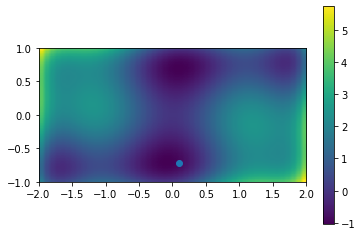

INITIAL GUESS: (x,y)=(1,1)
      fun: -1.0316284534898448
 hess_inv: array([[ 0.1296344 , -0.00844734],
       [-0.00844734,  0.06238673]])
      jac: array([-2.68220901e-07,  9.98377800e-07])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 13
     njev: 18
   status: 0
  success: True
        x: array([ 0.08984197, -0.71265635])
x_min =  0.08984196519304719
y_min =  -0.7126563463732559
Function estimated in the minima: -1.0316284534898448


INITIAL GUESS: (x,y)=(0,0)
x_min =  0.0
y_min =  0.0
Function estimated in the minima: 0.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import optimize
from scipy.optimize import brentq
from scipy.optimize import basinhopping
from math import sqrt

import pickle

%matplotlib inline

#find the global minima of the function
def sixhump(x):
    return (4 - 2.1*pow(x[0],2) +  pow(x[0],4)/3)*pow(x[0],2) + x[0]*x[1] + (4*pow(x[1],2) - 4)*pow(x[1],2)

#grid to evaluate the function
x = np.linspace(-2,2)
y = np.linspace(-1,1)
xg, yg = np.meshgrid(x, y)

x_min = optimize.minimize(sixhump, x0=[1,1])

plt.figure()
plt.imshow(sixhump([xg,yg]), extent=[-2,2,-1,1])
plt.colorbar()

plt.scatter(x_min.x[0], x_min.x[1])
plt.show()

print("INITIAL GUESS: (x,y)=(1,1)")
print(x_min)

print("x_min = ", x_min.x[0])
print("y_min = ", x_min.x[1])
print("Function estimated in the minima:", sixhump(x_min.x))

print("\n\nINITIAL GUESS: (x,y)=(0,0)")
x_min2 = optimize.minimize(sixhump, x0=[0,0])
print("x_min = ", x_min2.x[0])
print("y_min = ", x_min2.x[1])
print("Function estimated in the minima:", sixhump(x_min2.x))

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

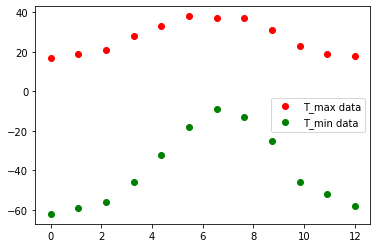

In [2]:
T_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
T_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

x = np.linspace(0,12,12)

plt.plot(x, T_max, color="red", marker="o", linestyle="", label="T_max data")
plt.plot(x, T_min, color="green", marker="o", linestyle="", label="T_min data")
plt.legend(loc='best')

Parameters fit T_max:  [ 5.73581645  3.24482319 23.09208915 15.77931504]


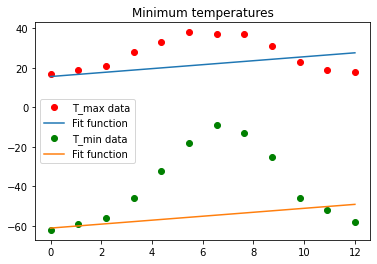

Parameters fit T_min:  [  6.16452586   2.79434514  52.64929311 -61.3209396 ]


In [3]:
#define a fit function: Gaussian function
def gauss(x, mu, sigma, A, B):
    return B + A*np.exp(-((x-mu)/sigma)**2)

#fit T_max
opt_max, cov_max = optimize.curve_fit(gauss, range(12), T_max, p0=[6, 1, 20, 40])
plt.plot(x, T_max, color="red", marker="o", linestyle="", label="T_max data")
plt.plot(x, gauss(*opt_max, x), label="Fit function")
plt.title("Maximum temperatures")
print("Parameters fit T_max: ", opt_max)


#fit T_min 
opt_min, cov_min = optimize.curve_fit(gauss, range(12), T_min, p0=[6, 1, 0, -60])
plt.plot(x, T_min, color="green", marker="o", linestyle="", label="T_min data")
plt.plot(x, gauss(*opt_min, x), label="Fit function")
plt.title("Minimum temperatures")
plt.legend(loc='best')
plt.show()
print("Parameters fit T_min: ", opt_min)

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [4]:

import pickle

with open('residuals_261.pkl', 'rb') as f:
    data = pickle.load(f)
    
data = np.load("data/residuals_261.pkl", allow_pickle=True).item()
df = pd.DataFrame(data)

#create the histogram of the residuals
Nbins = 250
fig, ax = plt.subplots(figsize=(10, 6))
h, bins, _ = plt.hist(df['residuals'], bins = Nbins, range=(-5, +5)) #create and plot the histogram
ax.set_title("Histogram of the residuals")
ax.set_xlabel('Residuals')
ax.set_ylabel('Counts')
fig.tight_layout()

#Poisson uncertainty:
sigma_P = [sqrt(h[i]) for i in range(len(bins)-1)]

#define a fit function: Gaussian function
def f(x, A, sigma, mu):
    return A*np.exp(- ((x - mu)/sigma)**2)

bins_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, pcov = optimize.curve_fit(f, bins_centers, h, p0=[350, 6, 5], full_output=False)
print("Parameters:\n", popt)
print("Covariance matrix:\n", pcov)
plt.plot(bins, f(bins, popt[0], popt[1], popt[2]), label='fitted function')
plt.legend(loc='best')

#goodness of the fit
ndof = len(bins) -1
print("Number of degrees of freedom: ", ndof)
chi2 = np.sum(((h - f(bins_centers, *popt))/popt[1])**2)
print("Chi2 =", chi2)
pvalue = 1. - scipy.stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)

FileNotFoundError: [Errno 2] No such file or directory: 'residuals_261.pkl'

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

Data from 2008 to 2012:
                0        1
4748  2008.00274 -2.94444
4749  2008.00548 -2.66667
4750  2008.00821 -2.66667
4751  2008.01095 -2.00000
4752  2008.01369 -1.94444
...          ...      ...
6204  2011.98836  3.44444
6205  2011.99110  1.27778
6206  2011.99384  2.88889
6207  2011.99658  1.83333
6208  2011.99932  1.50000

[1461 rows x 2 columns]


NameError: name 'ax' is not defined

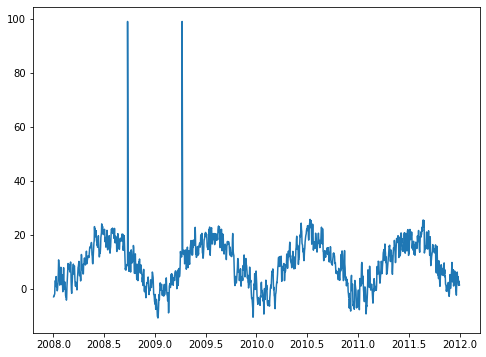

In [10]:


data = np.loadtxt('data/munich_temperatures_average_with_bad_data.txt')
dataf = pd.DataFrame(data)
df = dataf[(dataf[0] >= 2008) & (dataf[0] <= 2012)]
print("Data from 2008 to 2012:\n", df)

x = np.array(df[0])
y = np.array(df[1])

plt.figure(figsize=(8,6))
plt.plot(x, y, label='Data')
ax.set_xlabel('years')
ax.set_ylabel('Munich temperatures')
fig.tight_layout()


#define fit function
def f(t, a, b, c):
    return a*np.cos(2*np.pi*t+b)+c

#fit the data
popt, pcov = optimize.curve_fit(f, x, y)
print("\nPARAMETERS OF THE FIT WITH THE f(x) FUNCTION:")
print("a = ", popt[0], "\nb = ", popt[1], "\nc = ", popt[2])
plt.plot(x, f(x, *popt), label='Fit function f(x)')
plt.legend(loc='best')

#average temperature in Munich
mean_val = np.mean(y)
print("\nAverage temperature:", mean_val)

#daily average values 
t_max = max(f(x, *popt))
t_min = min(f(x, *popt))
print("Highest temperature predicted by the model: ", t_max)
print("Lowest temperature predicted by the model: ", t_min)


PARAMETERS OF THE FIT WITH THE g(x) FUNCTION:
a =  -9.982183229500329 
b =  1.0014440269314204 
c =  -5.904338726535512 
d =  9.398124623518875


NameError: name 'ax' is not defined

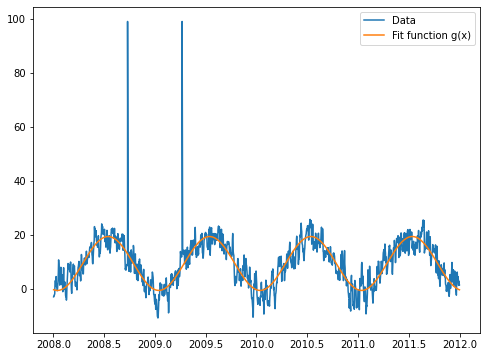

In [11]:
#new function
def g(t, a, b, c, d):
    return a*np.cos(2*np.pi*b*t+c)+d

popt2, pcov2 = optimize.curve_fit(g, x, y)
print("\nPARAMETERS OF THE FIT WITH THE g(x) FUNCTION:")
print("a = ", popt2[0], "\nb = ", popt2[1], "\nc = ", popt2[2], "\nd = ", popt2[3])

plt.figure(figsize=(8,6))
plt.plot(x, y, label='Data')
plt.plot(x, g(x, *popt2), label='Fit function g(x)')
plt.legend(loc='best')
ax.set_xlabel('years')
ax.set_ylabel('Munich temperatures')
fig.tight_layout()

#RSS of the functions
fSSR = np.sum((y - f(x, *popt))**2)
gSSR = np.sum((y - g(x, *popt2))**2)

print("The SSR for f(x) is: ", fSSR)
print("The SSR for g(x) is: ", gSSR)

In [12]:
#Fisher F-Test
from scipy.stats import f

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=True):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return 

Ftest(fSSR, gSSR, 2, 3, len(x))

NameError: name 'fSSR' is not defined